In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

from __future__ import division

import numpy as np
import os
#import mne
import pandas as pd
import matplotlib.pyplot as plt

from scipy import io, signal

from data_utils import *
from preprocessing import *
from models import *
from metrics import *

from sklearn.linear_model import LogisticRegression as LR
from sklearn import svm

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

no cv2... continuing...


Using Theano backend.
Using gpu device 0: Tesla K20c (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [2]:
X_s, Y_s, Y_l, ch_dict = import_data(1, downsample=5, ch_dict=True)

Converting time column to int64...


In [3]:
def create_mlp(input_len, output_len, hidden_len=None, activation='tanh'):
    
    if hidden_len is None:
        hidden_len = int(input_len * .5)
    
    model = Sequential()
    
    model.add(Dense(500, input_dim=input_len))
    model.add(Activation(activation))
    model.add(Dense(output_len))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer="adadelta")

    return model

def create_lr(input_len, output_len):
    model = Sequential()
    
    model.add(Dense(output_len, input_dim=input_len))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer="adadelta")

    return model

In [ ]:
# try LR instead
subj = 4
X, Y = X_s[subj], Y_s[subj]


label = 4
Y = (Y == label).astype(float)
X, Y = window_series(X, Y, width=500, fs=200, stride=100)


def split(x, split=.33):
    point = int(len(x)*split)
    return x[:point], x[point:]

(X3_train, X3_test), (Y3_train, Y3_test) = map(split, (X, Y))

bal = True
if bal:
    (X3_train, Y3_train), (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))
    #_, (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))

print "ratio of true:false : ", sum(list(Y3_train) + (Y3_test))/(len(Y3_train)+len(Y3_test))

mapper = lambda win: demean(window_psd(win, fs=200).reshape(-1))
X3_train, X3_test = rec_map(mapper, [X3_train, X3_test], 2)

model = LR(n_jobs=-1)

dim(Y)
Y3_pred = model.fit(X3_train, Y3_train).predict(X3_test)
print "fit"
metrics(Y3_train, model.predict(X3_train))
print "predict"
metrics(Y3_test, Y3_pred)

In [17]:
import copy

In [ ]:
plt.plot(Y_s[0][:10000])

In [5]:
# state vs rest
subj = 0
X, Y = X_s[subj], Y_s[subj]
#Y = narrow(Y, 4, .2, 1)


if False:
    channs = 'FC6 FT8 C4 T7 C5 C3 CP5 CP3 CP1 P3'.split()
    channs = map(lambda ch: ch_dict[ch], channs)
    X = X[:, channs]
elif True:
    channs = range(64)
    channs.remove(32)
    channs.remove(42) #remove m1, m2
    X = X[:, channs]
print "number of channels used:", X.shape[1]

fs = 200
window_size = 4000
X, Y = window_series(X, Y, width=window_size, fs=200, stride=100)

label = 4
rest = 1
Y_1 = (Y == label)
Y_0 = (Y == rest)
keep = np.sort(np.concatenate(map(lambda x: np.where(x)[0], [Y_1, Y_0])))
X, Y = map(lambda x: np.asarray(x)[keep], [X, Y])
Y = (Y == label).astype(int)

def split(x, split=.33):
    point = int(len(x)*(1-split))
    return x[:point], x[point:]

(X3_train, X3_test), (Y3_train, Y3_test) = map(split, (X, Y))
print "train:test :", len(X3_train), len(X3_test)

bal = True
if bal:
    (X3_train, Y3_train), (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))
    #_, (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))

print "ratio of true:false : ", sum(list(Y3_train) + (Y3_test))/(len(Y3_train)+len(Y3_test))

#print hann.shape, X3_train[0].shape
def feature_vect(wins, ftype=1):
    if ftype == 1:
        hann = signal.hann(window_size*fs//1000).reshape(1,-1)
        psd_mapper = lambda win: window_psd(win*hann, 
                                fs=fs, frange=(0,20))
        psds = map(psd_mapper, wins)
        stds = np.std(psds, axis=0)
        means = np.std(psds, axis=0)
        return map(lambda w: ((w-means)/stds).reshape(-1), psds)
    elif ftype == 2:
        stds = np.std(wins, axis=0)
        means = np.std(wins, axis=0)
        return map(lambda w: ((w-means)/stds).reshape(-1), wins)

mapper = lambda wins: feature_vect(wins, 1)
X3_train, X3_test = map(mapper, [X3_train, X3_test])


number of channels used: 62
train:test : 8099 3990
ratio of true:false :  0.5


In [ ]:
# model fit
mtype = 'SVM'
if mtype == 'LR':
    model = LR(n_jobs=-1)
elif mtype == 'SVM':
    model = svm.SVC(cache_size=1000)
elif mtype == 'linSVM':
    model = svm.LinearSVC()

print "number of features:", len(X3_train[0])

dim(X3_train), dim(X3_test)
dim(Y3_train), dim(Y3_test)

model.fit(np.asarray(X3_train), np.asarray(Y3_train))

Y3_pred = model.predict(np.asarray(X3_test))
print "fit"
metrics(Y3_train, model.predict(np.asarray(X3_train)))
print "predict"
metrics(Y3_test, Y3_pred)

KeyboardInterrupt: 

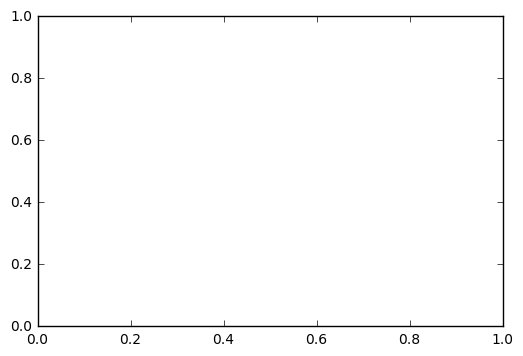

In [9]:
plt.plot(Y_s[:2000])

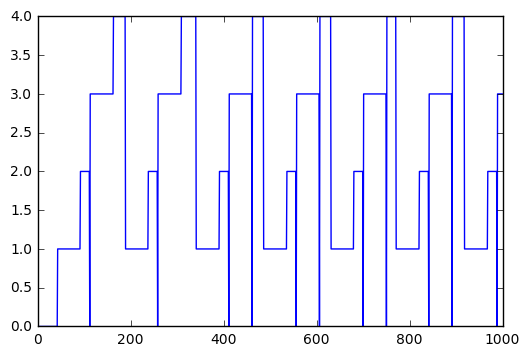

In [19]:
plt.plot(Y[:1000])

In [20]:
Y_1 = (Y == label)
Y_0 = (Y == rest)
keep = np.sort(np.concatenate(map(lambda x: np.where(x)[0], [Y_1, Y_0])))
X, YY = map(lambda x: np.asarray(x)[keep], [X, Y])

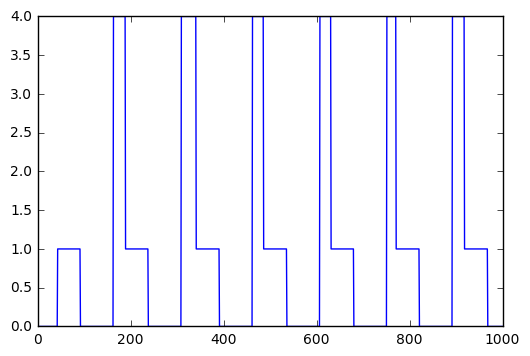

In [30]:
plt.plot((Y_1.astype(int)*Y+(Y_0).astype(int)*Y)[:1000])
#plt.plot(Y_0[:1000])

In [ ]:
Z = signal.convolve(X_s[0],X[0], mode='same')

In [ ]:
1

In [ ]:
dim(X3_train)

plt.figure(figsize=(12,12), dpi=100)
plt.imshow(X3_train, aspect='auto', interpolation='none')

print np.min(X3_train), np.max(X3_train)

In [ ]:
#scipy spectrogram
# state vs rest
subj = 0
X, Y = X_s[subj], Y_s[subj]
#Y = narrow(Y, 4, .2, 1)

fs = 200

channs = 'FC6 FT8 C4 T7 C5 C3 CP5 CP3 CP1 P3'.split()
print "number of channels used:", len(channs)
channs = map(lambda ch: ch_dict[ch], channs)
X = X[:, channs]
#print X.shape

label = 4
rest = 1
Y_1 = (Y == label)
Y_0 = (Y == rest)
keep = np.sort(np.concatenate(map(lambda x: np.where(x)[0], [Y_1, Y_0])))
X, Y = map(lambda x: x[keep], [X, Y])
Y = (Y == label).astype(int)

window_size = 600
X, Y = window_series(X, Y, width=window_size, fs=200, stride=300)
#dim(X)
#dim(Y)

def split(x, split=.33):
    point = int(len(x)*split)
    return x[:point], x[point:]

(X3_train, X3_test), (Y3_train, Y3_test) = map(split, (X, Y))

bal = True
if bal:
    (X3_train, Y3_train), (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))
    #_, (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))

print "ratio of true:false : ", sum(list(Y3_train) + (Y3_test))/(len(Y3_train)+len(Y3_test))

hann = signal.hann(window_size*fs//1000).reshape(1,-1)
#print hann.shape, X3_train[0].shape
mapper = lambda win: window_psd(normalize(win, mode='channel')*hann, 
                                fs=fs, frange=(0, 15)).reshape(-1)
X3_train, X3_test = rec_map(mapper, [X3_train, X3_test], 2)

# normalizer
if True:
    std = np.std(X3_train, axis=0)
    X3_train, X3_test = rec_map(lambda x: x/std, [X3_train, X3_test], 2)


model = LR(n_jobs=-1)

model.fit(np.asarray(X3_train), np.asarray(Y3_train))

Y3_pred = model.predict(np.asarray(X3_test))
print "fit"
metrics(Y3_train, model.predict(np.asarray(X3_train)))
print "predict"
metrics(Y3_test, Y3_pred)

In [ ]:
dim(X)

print X[0].T == (X_s[5][:120, channs])

In [ ]:
dim(X[0])
dim(X_s[0][:120, channs])

In [ ]:
plt.plot(X[0][3,:120])
plt.plot(X_s[0].T[channs[3],1000:1120])

In [ ]:
plt.plot(Y_s[0][:10000])